# Quantum data learning for quantum simulations in high-energy physics

## 1. Introduction

Let's start with the necessary imports...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit_machine_learning.algorithms.classifiers import (
    NeuralNetworkClassifier,
)
from qiskit_machine_learning.neural_networks import EstimatorQNN

from qcnn_hep_tutorial import LatticeSchwingerModel

algorithm_globals.random_seed = 12345

### 1.1 Classical Convolutional Neural Networks

Classical Convolutional Neural Networks (CCNNs) are a subclass of artificial neural networks which have the ability to determine particular features and patterns of a given input. Because of this, they are commonly used in image recognition and audio processing. 

The capability of determining features is a result of the two types of layers used in a CCNN, the convolutional layer and pooling layer. 

An example of a CCNN can be seen in Figure 1, where a CCNN is trained to determine whether an input image either contains a cat or a dog. To do so, the input image passes through a series of alternating convolutional (C) and pooling layers (P), all of which detect patterns and associate each pattern to a cat or a dog. The fully connected layer (FC) provides us with an output which allows us to determine whether the input image was a cat or dog.

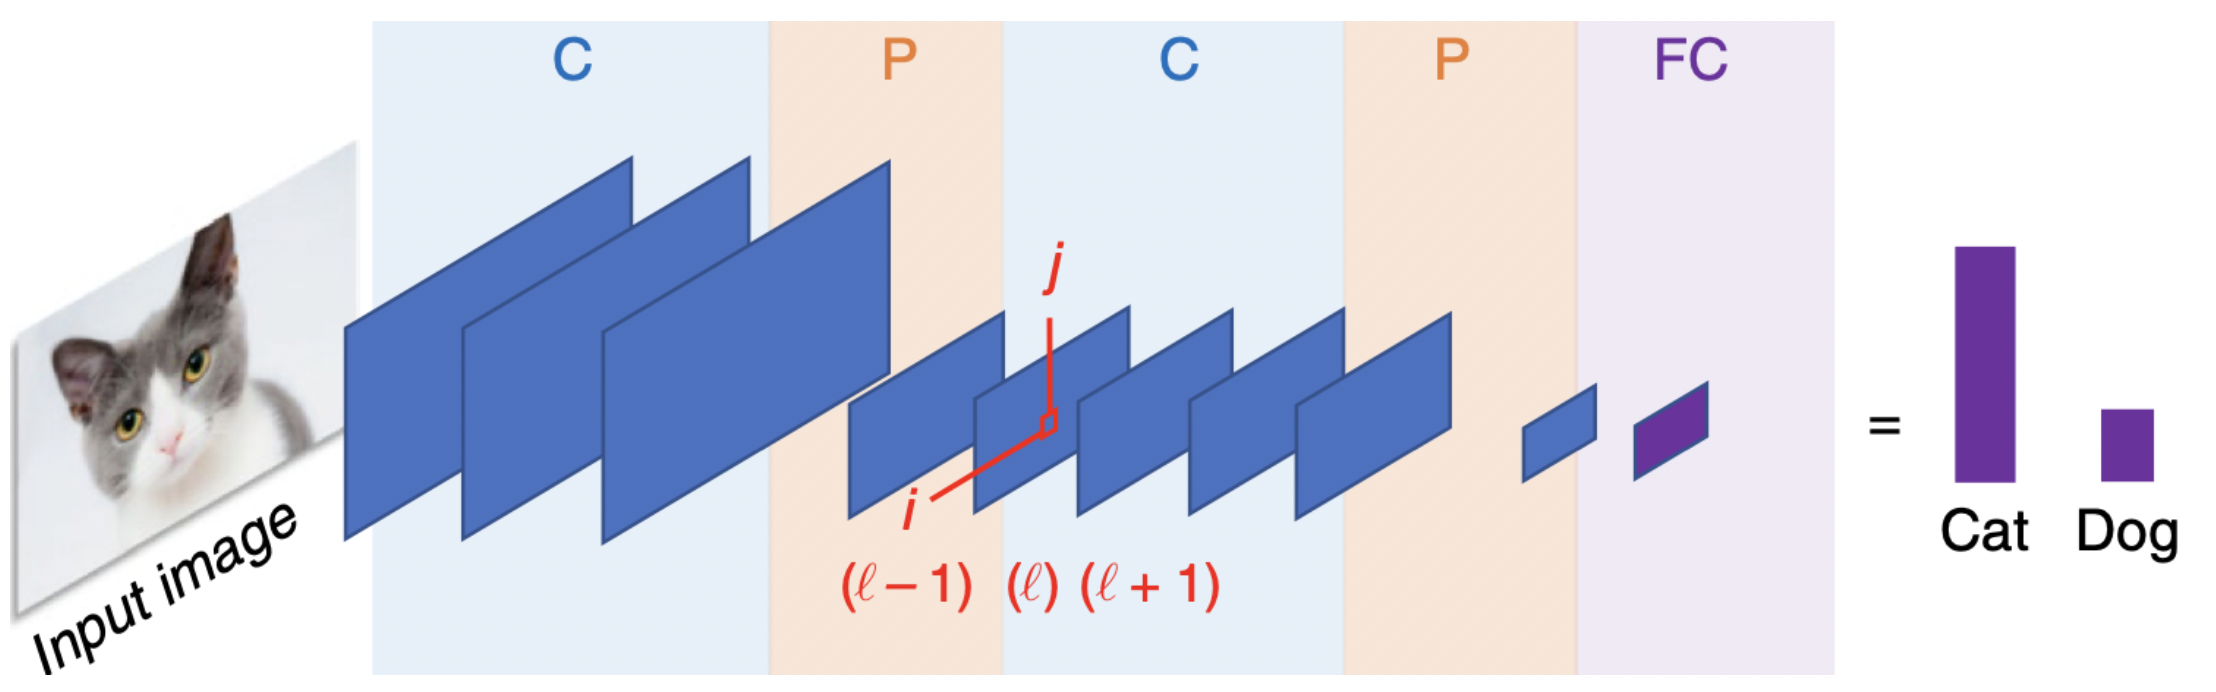

Figure 1. A schematic demonstration of the use of a CCNN to classify between images of a cat and dog. Here, we see the several convolutional and pooling layers being applied, all of which are decreasing in dimensionality due to the use of the pooling layers. The output of the CCNN determines whether the input image was a cat or dog. Image obtained form [1]. 

For further information on CCNN, see [2].

### 1.2 Quantum Convolutional Neural Networks 

Quantum Convolutional Neural Networks (QCNN) behave in a similar manner to CCNNs. First, we encode our data into a quantum circuit using a given feature map. In this tutorial, our feature map will actually be a Variational Quantum Eigensolver circuit, which we use to encode our data.

After encoding our data, we apply alternating convolutional and pooling layers, as defined in the coming sections. By applying these alternating layers, we reduce the dimensionality of our circuit until we are left with one qubit. We can then classify our data by measuring the output of this one remaining qubit, we can distinguish between possible phases for a phase recognition problem for the Schwinger model [3]. 

The aim is to learn quantum states provided as input data and their associated phases as labels, to then predict phases of unknown states in test data. To read more about the Schwinger model and its phases, the preparation of the input dataset using VQE as well as the model construction, please refer to the full paper _Quantum Data Learning for Quantum Simulations High Energy Physics paper_ [3].

The resulting model that we will build for recreating the paper results will look like the figure below.

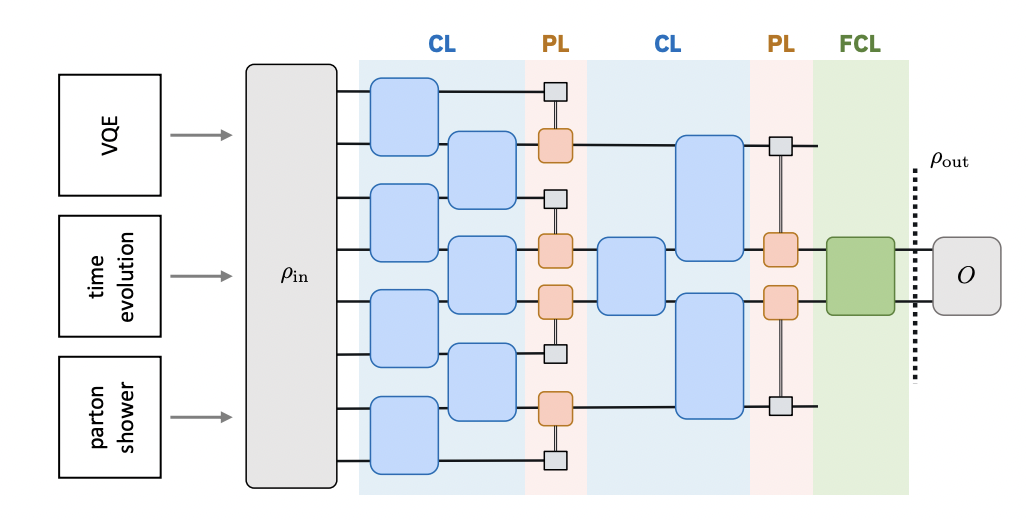

Figure 2. Representative QCNN circuit, composed of alternating convolution and pooling layers (denoted by CL and PL, respectively), followed by a fully connecter layer (FCL) and the measurement of the output state with an observable. The input state to the QCNN circuit is a quantum state, either in the form of a ground state generated with VQE, a time-evolved state through Hamiltonian simulation, or a multi-particle state from a phenomenological quantum parton shower simulation [3]. 

The paper itself runs three experiments, where data is generated from the following three different experiments:

 - Quantum simulation of the Schwinger model
 - Real-time evolution of (1 + 1)D Z2 gauge theory
 - Quantum parton shower simulation

For each of the three experiments described in the paper, the same QCNN was used for different analysis tasks. We will be specifically be looking at the Schwinger model experiment.

### 1.3  Define the Convolutional Layer

The Quantum Convolutional Layer will consist of a series of two qubit unitary operators, which recognize and determine relationships between the qubits in our circuit. The unitary gates are defined below in the next section. 

In the QCNN, each layer contains parametrized circuits, meaning we alter our output result by adjusting the parameters of each layer. When training our QCNN, it is these parameters that are adjusted to reduce the loss function of our QCNN. 

First, we will define the Convolutional Layers of our QCNN, which are applied to the qubits after the data has been encoded through use of the feature map. 

The convolutional layer makes use of a kernel, which can determine features and patterns of a particular input. An example of this is feature detection in an image, where different layers detect particular patterns in the input image. This is demonstrated in Figure 1, where the $l^{th}$ layer recognizes features and patterns along the $ij$ plane. It can then associate such features with a given output in the training process, and can use this process to train the dataset. 

Let's define the convolutional circuit we will use in the _Quantum Data Learning for Quantum Simulations High Energy Physics paper_ [3].

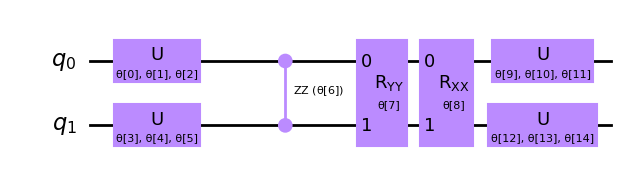

In [2]:
def conv_circuit(params):
    """
    Create a two-qubit convolutional circuit segment.

    Args:
        params: List of 15 parameters for the two-qubit unitary operation.

    Returns:
        QuantumCircuit: A quantum circuit representing the convolution operation on two qubits.
    """
    target = QuantumCircuit(2)
    # firstly, apply single-qubit rotations
    target.u(params[0], params[1], params[2], 0)
    target.u(params[3], params[4], params[5], 1)
    # now apply two-qubit entangling gates
    target.rzz(params[6], 0, 1)
    target.ryy(params[7], 0, 1)
    target.rxx(params[8], 0, 1)
    # finally apply a second set of single-qubit rotations
    target.u(params[9], params[10], params[11], 0)
    target.u(params[12], params[13], params[14], 1)
    return target

### ACTIVITY 1 ### 
# Draw the convolutional layer with 15 params, it should look something like below:
# Hint: you should use the ParameterVector object defined here - https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.ParameterVector

Now that we have defined these unitaries, it is time to create a function for the convolutional layer in our QCNN. To do so, we apply the two qubit unitary to neighboring qubits as seen in the ``conv_layer`` function below.

Note that we first apply the two qubit unitary to all even pairs of qubits followed by applying to odd pairs of qubits in a circular coupling manner, i.e. the as well as neighboring qubits being coupled, the first and final qubit are also coupled through a unitary gate.

In [3]:
def conv_layer(num_qubits, param_prefix):
    """
    Create a convolutional layer for a given number of qubits.

    Args:
        num_qubits: Number of qubits in the layer.
        param_prefix: Prefix for naming the parameters.

    Returns:
        QuantumCircuit: A quantum circuit representing the convolutional layer.
    """
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    params = ParameterVector(param_prefix, length=(num_qubits // 2) * 15)
    param_index = 0
    for q in range(0, num_qubits - 1, 2):
        conv_qc = conv_circuit(params[param_index:param_index + 15])
        qc.compose(conv_qc, [q, q + 1], inplace=True)
        param_index += 15
    return qc

### 1.4  Define the Pooling Layer

A pooling layer reduces the dimensionality of the input data, reducing the computational cost and amount of learning parameters in the model. 

For a Quantum Pooling Layer specifically, we cannot do the same as is done classically to reduce the dimension, i.e. the number of qubits in our circuit. Instead, we reduce the number of qubits by performing operations upon each until a specific point and then disregard certain qubits in a specific layer. It is these layers where we stop performing operations on certain qubits that we call our 'pooling layer'.

Let's define the pooling circuit to build the pooling layer for this experiment.

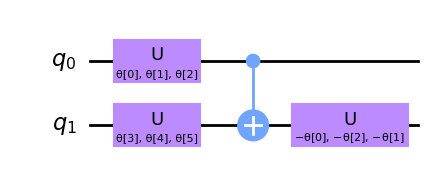

In [4]:
def pool_circuit(params):
    """
    Create a pooling circuit segment for a pair of qubits.

    Args:
        params: List of 6 parameters for the pooling operation.

    Returns:
        QuantumCircuit: A quantum circuit representing the pooling operation on two qubits.
    """
    target = QuantumCircuit(2)
    target.u(params[0], params[1], params[2], 0)
    target.u(params[3], params[4], params[5], 1)
    target.cx(0, 1)
    target.u(-params[0], -params[2], -params[1], 1)  # apply the inverse
    return target

### ACTIVITY 2 ### 
# Draw the pooling circuit with 6 params, it should look something like below:
# Hint: you should use the ParameterVector object defined here - https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.ParameterVector

We apply this two qubit pooling layer to different pairs of qubits to create our pooling layer for N qubits. 

In [5]:
def pool_layer(qubit_pairs, param_prefix):
    """
    Pooling layer that combines qubits based on the provided pairs using a parameter vector.

    Args:
        qubit_pairs: List of tuples, each containing pairs of qubits to pool.
        param_prefix: Prefix for naming the parameters.

    Returns:
        QuantumCircuit: QuantumCircuit for the pooling layer.
    """
    unique_qubits = sorted(set([q for pair in qubit_pairs for q in pair]))
    num_qubits = len(unique_qubits)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    total_params = len(qubit_pairs) * 6
    params = ParameterVector(param_prefix, length=total_params)
    param_index = 0
    for pair in qubit_pairs:
        # calculate the relative qubit index in the pool layer's circuit
        relative_indices = [unique_qubits.index(pair[0]), unique_qubits.index(pair[1])]
        # create a pooling circuit and add it to the main circuit
        pool_qc = pool_circuit(params[param_index:param_index + 6])
        qc.compose(pool_qc, relative_indices, inplace=True)
        param_index += 6
    return qc

### 1.5  Bring the QCNN together

Now that we have defined both the convolutional layers it is now time to build our QCNN, which will consist of alternating pooling and convolutional layers.

In [6]:
def generate_qcnn_circuit(num_qubits):
    """
    Create a sequence of alternating convolution and pooling layers with specific parameter prefixes.

    Args:
        num_qubits: The total number of qubits in the QCNN circuit.

    Returns:
        QuantumCircuit: A quantum circuit representing the QCNN with specific parameter prefixes.
    """
    circuit = QuantumCircuit(num_qubits)

    ### first layer ###
    qubits_in_layer = list(range(num_qubits))

    # first convolutional layer
    for q in qubits_in_layer[:-1:2]:
        conv_layer_circuit = conv_layer(2, f"c1_{q}_{q+1}")
        circuit.compose(conv_layer_circuit, [q, q + 1], inplace=True)
    for q in qubits_in_layer[1:-1:2]:
        conv_layer_circuit = conv_layer(2, f"c1_{q}_{q+1}")
        circuit.compose(conv_layer_circuit, [q, q + 1], inplace=True)
    circuit.barrier()

    # first pooling layer
    for q in qubits_in_layer[:num_qubits - 1:2]:
        pool_layer_circuit = pool_layer([(q, q + 1)], f"p1_{q}_{q+1}")
        circuit.compose(pool_layer_circuit, [q, q + 1], inplace=True)
    circuit.barrier()

    ### second Layer ###
    qubits_in_layer = list(range(1, num_qubits, 2))

    # second convolutional layer
    for q in qubits_in_layer[:-1:2]:
        conv_layer_circuit = conv_layer(2, f"c2_{q}_{q+2}")
        circuit.compose(conv_layer_circuit, [q, q + 2], inplace=True)
    for q in qubits_in_layer[1:-1:2]:
        conv_layer_circuit = conv_layer(2, f"c2_{q}_{q+2}")
        circuit.compose(conv_layer_circuit, [q, q + 2], inplace=True)
    circuit.barrier()

    # second pooling layer
    for q in qubits_in_layer[:-1:2]:
        pool_layer_circuit = pool_layer([(q, q + 2)], f"p2_{q}_{q+2}")
        circuit.compose(pool_layer_circuit, [q, q + 2], inplace=True)
    circuit.barrier()

    ### third layer ###
    qubits_in_layer = list(range(3, num_qubits, 4))

    # third convolutional layer
    conv_layer_circuit = conv_layer(2, f"c3_{qubits_in_layer[0]}_{qubits_in_layer[1]}")  # Use unique prefix
    circuit.compose(conv_layer_circuit, [qubits_in_layer[0], qubits_in_layer[1]], inplace=True)
    circuit.barrier()

    # third pooling layer
    pool_layer_circuit = pool_layer([(qubits_in_layer[0], qubits_in_layer[1])], f"p3_{qubits_in_layer[0]}_{qubits_in_layer[1]}")  # Use unique prefix
    circuit.compose(pool_layer_circuit, [qubits_in_layer[0], qubits_in_layer[1]], inplace=True)
    circuit.barrier()

    return circuit

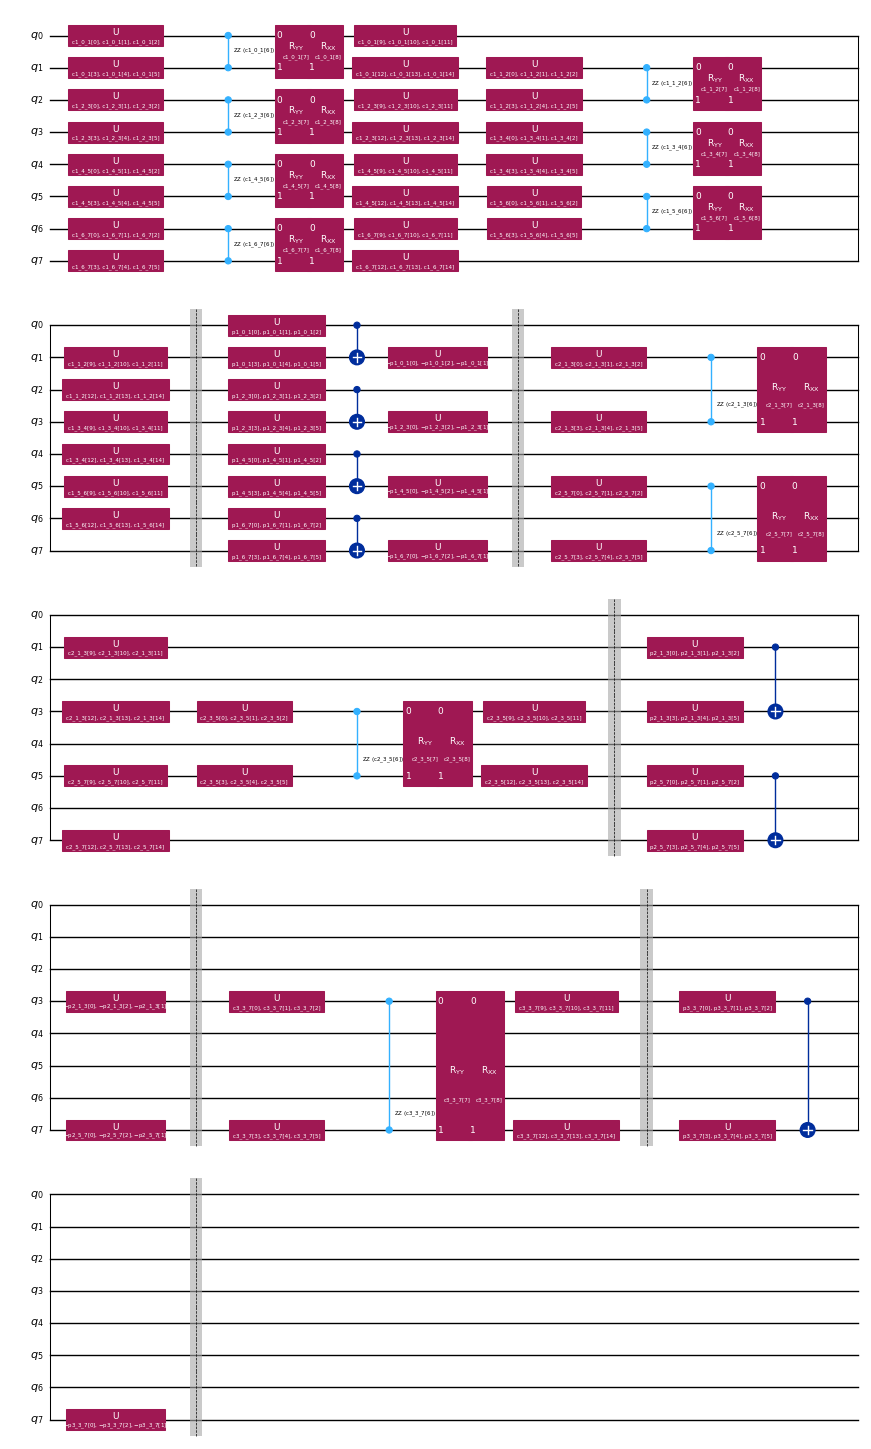

In [7]:
# test the above with example input
num_qubits = 8
qcnn_circuit = generate_qcnn_circuit(num_qubits)
qcnn_circuit.draw('mpl', scale=0.5) 

### 1.6 Data Preparation

The dataset we will be using below is extracted from the results used directly in the paper _Quantum Data Learning for Quantum Simulations High Energy Physics paper_ [3]. 

For each of the three experiments described in the paper, the above-defined QCNN was used for different analysis tasks. We will be specifically be looking at the results from the quantum simulation of the Schwinger model experiment, for which an extract of the results have been stored in this repository, along with an accompanying notebook `schwinger_vqe.ipynb`, which you could use to reproduce the dataset.

From the sample data provided, you will find the ground state results for each point in a 2D parameter scan over the Schwinger model, found in `params_VQE_list` below. The `label_list` includes our true labels to test our model performance. 

We split this data into training and test datasets such that we have a sufficient dataset for the model training step and we can reserve some unseen data to test the model. 

Please note, you will also find mass and coupling data describing the masses used in the experiment such that we can label our plots correctly. We are only using this for the plot below to visualize the train and test split of the data. 

In [8]:
file_path='./data/eps0.5_g1_vary_m_-2.0_2.0_0.05_SLSQP_EvolvedOperatorAnsatz_minRev_initPrevOpt_reps5'
params_VQE_list = np.load(file_path + "_VQEparams.npy").tolist()

In [9]:
path = 'results/data/'
mass_min = -2.0
mass_max = 2.0
mass_step = 0.05
mass_list = np.arange(mass_min,mass_max+mass_step,mass_step)
num_data = mass_list.shape[0]
label_list = [-1]*num_data
mass_crit = 0.143  #obtained from ED, June 10, 2023
count = 0
for index, mass in enumerate(mass_list):
    if mass>mass_crit:
        label_list[index] = 1
        count += 1

train_ratio = 0.8
num_train = int(num_data*train_ratio)
index_all = list(range(num_data))
num_test = num_data - num_train

#for data loading
index_train = np.load(path+'index_train.npy')
index_test = np.load(path+'index_test.npy')

params_VQE_train = []
mass_list_train = []
label_list_train = []

params_VQE_test = []
mass_list_test = []
label_list_test = []

for index in index_train:
    params_VQE_train.append(params_VQE_list[index])
    mass_list_train.append(mass_list[index])
    label_list_train.append(label_list[index])
for index in index_test:
    params_VQE_test.append(params_VQE_list[index])
    mass_list_test.append(mass_list[index])
    label_list_test.append(label_list[index])

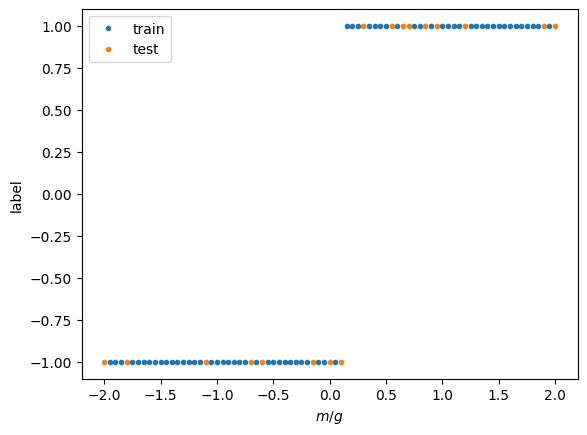

In [10]:
plt.plot(mass_list_train,label_list_train,'.',label='train')
plt.plot(mass_list_test,label_list_test,'.',label='test')
plt.legend()
plt.xlabel('$m/g$')
plt.ylabel('label')
plt.show()

### 1.7 Modeling our QCNN

We encode our dataset in the following `make_feature_map` function, which will be used to draw upon the data referenced above and encode the data in such a way that the model can process it.

In [11]:
def make_feature_map(num_qubits, num_layers_VQE):
    """
    Create a VQE ansatz circuit with an initial state |1010...>.

    Args:
        num_qubits: Number of qubits in the circuit.
        num_layers_VQE: Number of layers in the ansatz.

    Returns:
        A QuantumCircuit object representing the VQE ansatz.
    """
    model = LatticeSchwingerModel(mass=0.5, coupling=1.0, num_sites=num_qubits, spacing=2.0, left_gauge=0.5)
    H_op = model.get_hamiltonian()

    init_circ = QuantumCircuit(num_qubits)
    for q in range(0, num_qubits, 2):
        init_circ.x(q)

    
    ### ACTIVITY 3 ### 
    ## complete fields in the EvolvedOperatorAnsatz
    ansatz = EvolvedOperatorAnsatz(
        operators= # COMPLETE HERE #, 
        reps= # COMPLETE HERE #, 
        evolution= # COMPLETE HERE #, 
        parameter_prefix= # COMPLETE HERE #, 
        initial_state= # COMPLETE HERE #, 
    )

    return ansatz

### 1.8 Training our QCNN

It's time to pull everything together and build our model using our training data. 

We will use the COBYLA optimizer to train our classifier, which is a numerical optimization method commonly used for classification machine learning algorithms.

We then place the the callback function, optimizer and operator of our QCNN created above into Qiskit Machine Learning's built in Neural Network Classifier, which we can then use to train our model. 

Since model training may take a long time we have already pre-trained the model for the purpose of this tutorial, but please feel free to try this at home!

In [12]:
def get_qnn(num_qubits):
    ### ACTIVITY 4 ### 
    # complete this function such that we return an EstimatorQNN object that takes num_qubits as an argument 
    # Hint: you might want to use the following measurement_observable = SparsePauliOp.from_sparse_list([('Z', [0])], [1], num_qubits)

In [13]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

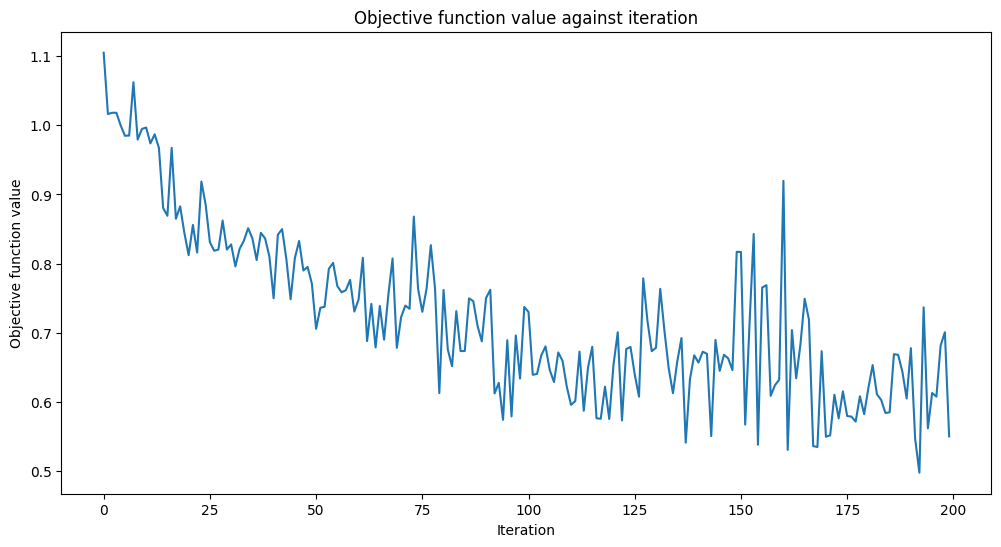

Accuracy from the train data : 98.44%


In [14]:
# example usage
num_qubits = 8
# each layer uses 3 parameters
num_layers_VQE = len(params_VQE_train[0]) // 3

# generate the feature map to encode data for the classification problem
# in this case, the feature map is actually a VQE ansatz
feature_map = make_feature_map(num_qubits, num_layers_VQE)

# construct neural network classifier
qnn = get_qnn(num_qubits)
classifier = NeuralNetworkClassifier(
    qnn,
    loss="squared_error",
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# ensure data has the correct shape
feature_map_params = feature_map.parameters
train_data_list_np = np.array(params_VQE_train)
train_label_list_np = np.array(label_list_train)

# fit the classifier with the input data
classifier.fit(train_data_list_np, train_label_list_np)

# score the classifier
score = classifier.score(train_data_list_np, train_label_list_np)
print(f"Accuracy from the train data : {np.round(100 * score, 2)}%")

### 1.7 Testing our QCNN

We can finally test the performance of our model in the task of predicting phases of unknown states in the test data.

In [15]:
# test on the unseen data
test_data_list_np = np.array(params_VQE_test)
test_label_list_np = np.asarray(label_list_test)
predicted_labels = classifier.predict(test_data_list_np)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(test_data_list_np, test_label_list_np), 2)}%")

Accuracy from the test data : 94.12%


### References

[1] _Quantum convolutional neural networks._ Cong, I., Choi, S. & Lukin, M.D. Nat. Phys. 15, 1273–1278 (2019). https://doi.org/10.1038/s41567-019-0648-8

[2] _IBM Convolutional Neural Networks_ https://www.ibm.com/cloud/learn/convolutional-neural-networks

[3] _Quantum data learning for quantum simulations in high-energy physics._ Phys. Rev. Research 5, 043250. Nagano, Lento and Miessen, Alexander and Onodera, Tamiya and Tavernelli, Ivano and Tacchino, Francesco and Terashi, Koji. https://arxiv.org/pdf/2306.17214